In [ ]:
## Imports ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.model_selection import (LeaveOneOut, RandomizedSearchCV,
                                     RepeatedKFold, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.figsize"] = (6,4.5)

In [3]:
## Read in Data ## 
df_orig = pd.read_csv('../data/processed/CPA-virtual_database.csv')
df = df_orig[df_orig['Rxn_Type'] == 'Training']

y, x = df.loc[:, 'ddG'],df.loc[:, df.columns[9:]]

In [4]:
## Train-test split ##
 
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=25)

In [5]:
## Normalise Data ##
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [6]:
## Hyperparameter Tuning ##

eta = np.divide(range(1,10),10)
gamma = range(0,10)
max_depth = range(0,20)
subsample = np.divide(range(1,10),10)
min_child_weight = range(0,5)


random_grid = {'eta': eta,
               'gamma': gamma,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight
               }

In [ ]:
regressor = XGBRegressor()

hp_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, cv=10, n_iter=500,scoring='r2', random_state=25)
hp_random.fit(X_train, y_train)
print(hp_random.best_params_)
hp_tune_1 = pd.DataFrame(hp_random.cv_results_)

In [ ]:
## Hyperparameter Tuning ##

eta = np.divide(range(1,2),10)
max_depth = range(5,25)
subsample = np.divide(range(3,8),10)
min_child_weight = range(0,5)


random_grid = {'eta': eta,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight
               }

In [ ]:
from sklearn.model_selection import GridSearchCV


regressor = XGBRegressor(gamma=0)

hp_random = GridSearchCV(estimator = regressor, param_grid = random_grid, cv=10, scoring='r2')
hp_random.fit(X_train, y_train)
print(hp_random.best_params_)
hp_tune_2 = pd.DataFrame(hp_random.cv_results_)

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.5}


In [6]:
## Train Model ##
regressor_tuned = XGBRegressor(subsample=0.5, min_child_weight=0, max_depth=5, gamma=0, eta=0.1)
model = regressor_tuned.fit(X_train, y_train)
train_predict = model.predict(X_train)

Train MAE = 0.12452864967056157
Train R^2 = 0.9837927686331099


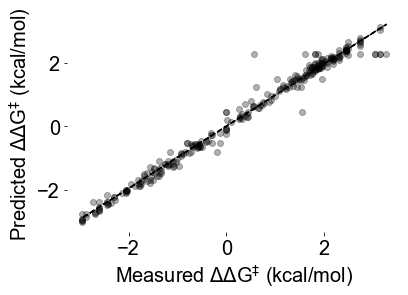

In [13]:
## Plot Training Model ##

plt.scatter(y_train,train_predict, c='black', alpha=0.3)
plt.box(on=None)
print('Train MAE = ' + str(mae(y_train,train_predict)))
print('Train R^2 = ' + str(r2_score(y_train,train_predict)))
plt.xlabel('Measured ΔΔG$^‡$ (kcal/mol)')
plt.ylabel('Predicted ΔΔG$^‡$ (kcal/mol)')
# plt.title('XGB')
m, b = np.polyfit(y_train, train_predict, 1)
plt.plot(y_train,m*y_train+b, '--', c='black', zorder = 0)

In [ ]:
# K-fold Cross validation score
from sklearn.model_selection import cross_val_predict


rep_cv = RepeatedKFold(n_splits=10,n_repeats=10)
cv_model = cross_validate(
    regressor_tuned,
    X_train,
    y_train,
    cv = rep_cv,
    scoring=('r2','neg_mean_absolute_error')
)
cv_r2 = (np.average(cv_model['test_r2']))

#LOO
loo = LeaveOneOut()
loo_model = cross_val_predict(
    regressor_tuned,
    X_train,
    y_train,
    cv = loo,
)
loo_r2 = r2_score(y_train,loo_model)  


In [15]:
## Predict X Test ##

X_test_ = scaler.transform(X_test)
test_predict = model.predict(X_test_)

Test MAE = 0.24710863094827903
Test R^2 = 0.9627920032901305


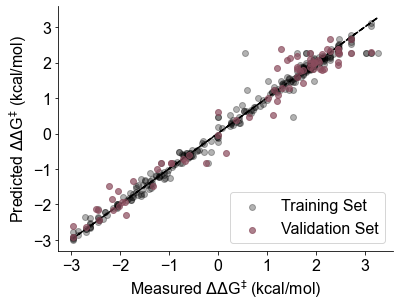

In [58]:
## Plot Test Model ##
ax = plt.subplot(111)

ax.plot(y_train,y_train, '--', c='black',zorder = 0)

plt.xlabel('Measured ΔΔG$^‡$ (kcal/mol)')
plt.ylabel('Predicted ΔΔG$^‡$ (kcal/mol)')

plt.scatter(y_train,train_predict, c='black', alpha=0.3, label='Training Set')

plt.scatter(y_test,test_predict, facecolor='#8a4c5d', alpha=0.7, zorder = 20, label = 'Validation Set')

# plt.title('XGB')
plt.xlabel('Measured $\Delta\Delta$G$^‡$ (kcal/mol)')
plt.ylabel('Predicted $\Delta\Delta$G$^‡$ (kcal/mol)')
plt.legend(loc="lower right")

# ax = plt.subplot(111)
# ax.plot(x, y)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)
plt.xticks([-3,-2,-1,0,1,2,3])

print('Test MAE = ' + str(mae(y_test,test_predict)))
print('Test R^2 = ' + str(r2_score(y_test,test_predict)))

plt.savefig('./test.png', dpi=300)

plt.show()